There has been a tremendous amount of innovation in RNN architectures, culminating in several complex designs that have proven successful in practice. In particular, the most designs feature mechanisms for mitigating the notorious numerical instability faced by RNNs, as typified by vanishing and exploding gradients.

In this chapter, we introduce the key ideas behind the most successfull RNN architectures for sequences, which stem from two papers.

1. Long Short-Term Memory (LSTM) introduces the memory cell, a unit of computation that replaces traditional nodes in the hidden layer of a network.

2. Bidirectional Recurrent Neural Networks introduces an architecture in which information from both the future and the past are used to determine the output at any point in the sequence.

# 10.1 Long Short-Term Memory (LSTM)

The problems of learning long-term dependencies became sailent in RNN, thus leading to proposing LSTM, which successfully adressed vanishing gradients problems. LSTMs resemble standard RNNs but here each ordinary recurrent node is replaced by a 'memory cell'. Each memory cell contains an 'internal state', i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 10.1.1 Gated Memory Cell

Each memory cell is equipped with an internal state and a number of multiplicative gates that determine whether 1) a given input should impact the internal state (input gate) 2) the internal state should be flushed to 0 (forget gate) 3) the internal state of a given neuron should be allowed to impact the cell's output (output gate).

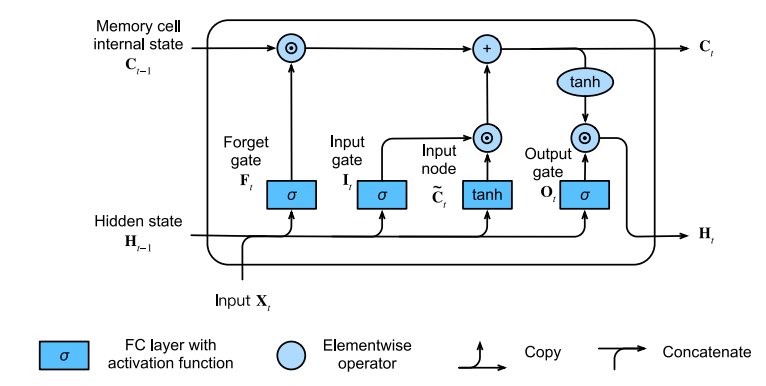

The core concept is maintaining memory cell internal state, which contains internal state of long and short-term history.
 - Forget gate: How much should we forget the previous information $C_{t-1}$?
 - Input gate: How much should we take account $\tilde{C_t}$?
 - Input node: Calculate current information $\tilde{C_t}$
 - Output gate: Produce output $O_t$


 Cell state: preserves long-term memory (so that we prevent gradient exploding/vanishing)
 
 Hidden state: preserves short-term memory (as before)



## 10.1.1 Implementation from Scratch

### Initializing Model Parameters

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
        init_weight(num_hiddens, num_hiddens),
        nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple() # Input gate
        self.W_xf, self.W_hf, self.b_f = triple() # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple() # Output gate
        self.W_xc, self.W_hc, self.b_c = triple() # Input node

In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
        device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
        device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)

        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    
    return outputs, (H, C)

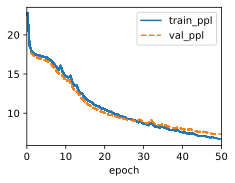

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.1.3 Concise Implementation

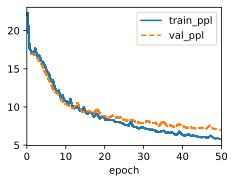

In [5]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)
    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)
    
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [10]:
model.predict('if i were you a banana will', 20, data.vocab, d2l.try_gpu())

'if i were you a banana will so i the the the th'